In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import scipy
import lightgbm as lgb

In [2]:
gp = pd.read_csv('aggregated_features.csv')

In [3]:
train = pd.read_csv('data/train.csv', parse_dates=['activation_date'])
test = pd.read_csv('data/test.csv', parse_dates=['activation_date'])

train = train.merge(gp, on='user_id', how='left')
test = test.merge(gp, on='user_id', how='left')

agg_cols = list(gp.columns)[1:]

del gp; gc.collect()

train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,activation_date,user_type,image,image_top_1,deal_probability,avg_days_up_user,avg_times_up_user,med_days_up_user,med_times_up_user,n_user_items
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789,8.000000,2.000000,8.0,2.0,2.0
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000,NaN,NaN,NaN,NaN,NaN
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177,4.428571,1.142857,3.0,1.0,9.0
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323,16.714286,2.642857,18.0,3.0,32.0
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797,NaN,NaN,NaN,NaN,NaN


In [4]:
train = train.sort_values(['activation_date']).reset_index(drop=True)

In [5]:
train_index, valid_index = train_test_split(np.arange(len(train)), test_size=0.1, random_state=519)

In [6]:
train.loc[train_index, 'activation_date'].dt.weekday.value_counts()

0    207048
6    205318
1    201131
2    196631
3    191293
4    176527
5    175133
Name: activation_date, dtype: int64

In [7]:
train.loc[valid_index, 'activation_date'].dt.weekday.value_counts()

0    23007
6    22614
1    22289
2    21884
3    21422
4    19599
5    19528
Name: activation_date, dtype: int64

In [8]:
test.loc[:, 'activation_date'].dt.weekday.value_counts()

2    81888
1    81114
0    80191
3    77177
4    70366
6    58909
5    58793
Name: activation_date, dtype: int64

One more thing about the approach that I haven't mentioned yet is that we will have quite some NaN values because not every ID in `train` and `test` occurs in `train_active` and `test_active`. Let's check how big that problem is.

In [9]:
train[agg_cols].isnull().any(axis=1).sum() / len(train) * 100

22.407185198586692

In [10]:
test[agg_cols].isnull().any(axis=1).sum() / len(test) * 100

24.354198545348694

In [11]:
train.isnull().sum(), test.isnull().sum()

(item_id                      0
 user_id                      0
 region                       0
 city                         0
 parent_category_name         0
 category_name                0
 param_1                  61576
 param_2                 654542
 param_3                 862565
 title                        0
 description             116276
 price                    85362
 item_seq_number              0
 activation_date              0
 user_type                    0
 image                   112588
 image_top_1             112588
 deal_probability             0
 avg_days_up_user        336875
 avg_times_up_user       336875
 med_days_up_user        336875
 med_times_up_user       336875
 n_user_items            336875
 dtype: int64, item_id                      0
 user_id                      0
 region                       0
 city                         0
 parent_category_name         0
 category_name                0
 param_1                  22910
 param_2                 2

We have missing features for 22.41% of train and 24.35% of test data. That's not perfect but certainly acceptable. Onto some more basic feature engineering with ideas from [a great kernel](https://www.kaggle.com/tunguz/bow-meta-text-and-dense-features-lb-0-2241?scriptVersionId=3603709).

In [12]:
import string

In [13]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])


for df in [train, test]:
    df['description'].fillna('unknowndescription', inplace=True)
    df['title'].fillna('unknowntitle', inplace=True)

    df['weekday'] = pd.to_datetime(df['activation_date']).dt.day
    
    for col in ['description', 'title']:
        df['num_words_' + col] = df[col].apply(lambda comment: len(comment.split()))
        df['num_unique_words_' + col] = df[col].apply(lambda comment: len(set(w for w in comment.split())))

    df['words_vs_unique_title'] = df['num_unique_words_title'] / df['num_words_title'] * 100
    df['words_vs_unique_description'] = df['num_unique_words_description'] / df['num_words_description'] * 100
    
    df['city'] = df['region'] + '_' + df['city']
    df['num_desc_punct'] = df['description'].apply(lambda x: count(x, set(string.punctuation)))
    
    for col in agg_cols:
        df[col].fillna(-1, inplace=True)
    
    for col in ['price', 'image_top_1']:
         df[col].fillna(-1, inplace=True)
            
    for col in ['param_1', 'param_2', 'param_3']:
         df[col].fillna('khwinkaggle', inplace=True)

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khyeh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
count_vectorizer_title = CountVectorizer(stop_words=stopwords.words('russian'), lowercase=True, min_df=25)

title_counts = count_vectorizer_title.fit_transform(train['title'].append(test['title']))

train_title_counts = title_counts[:len(train)]
test_title_counts = title_counts[len(train):]


count_vectorizer_desc = TfidfVectorizer(stop_words=stopwords.words('russian'), 
                                        lowercase=True, ngram_range=(1, 2),
                                        max_features=15000)

desc_counts = count_vectorizer_desc.fit_transform(train['description'].append(test['description']))

train_desc_counts = desc_counts[:len(train)]
test_desc_counts = desc_counts[len(train):]

train_title_counts.shape, train_desc_counts.shape

((1503424, 16447), (1503424, 15000))

In [16]:
target = 'deal_probability'
predictors = [
    'num_desc_punct', 
    'words_vs_unique_description', 'num_unique_words_description', 'num_unique_words_title', 'num_words_description', 'num_words_title',
    'avg_times_up_user', 'avg_days_up_user', 'n_user_items', 
    'price', 'item_seq_number'
]
categorical = [
    'image_top_1', 'param_1', 'param_2', 'param_3', 
    'city', 'region', 'category_name', 'parent_category_name', 'user_type'
]

predictors = predictors + categorical

In [17]:
for feature in categorical:
    print(f'Transforming {feature}...')
    encoder = LabelEncoder()
    encoder.fit(train[feature].append(test[feature]).astype(str))
    
    train[feature] = encoder.transform(train[feature].astype(str))
    test[feature] = encoder.transform(test[feature].astype(str))

Transforming image_top_1...
Transforming param_1...
Transforming param_2...
Transforming param_3...
Transforming city...
Transforming region...
Transforming category_name...
Transforming parent_category_name...
Transforming user_type...


In [18]:
for feature in ['image_top_1']:
    gp = train.groupby(feature)[feature].count()
    train.loc[:, feature+'_cnt'] = train[feature].map(gp)

In [19]:
from sklearn.model_selection import KFold
fold_num = 10
kf = KFold(fold_num, shuffle=True, random_state=411519719)

mean_enc_cols = ['item_seq_number', 'image_top_1']

for col in mean_enc_cols:    
    
    train.loc[:, col+'_dp_mean_enc'] = np.zeros((train.shape[0],))
    train.loc[:, col+'_dp_std_enc'] = np.zeros((train.shape[0],))
    test.loc[:, col+'_dp_mean_enc'] = np.zeros((test.shape[0],))
    test.loc[:, col+'_dp_std_enc'] = np.zeros((test.shape[0],))
    
    for train_ix, val_ix in kf.split(train):
        tr_X = train.loc[train_ix, :]
    
        gp = tr_X.groupby(col)['deal_probability']
        mapping, mapping_std = gp.mean(), gp.std()
        
        train.loc[val_ix, col+'_dp_mean_enc'] = train.loc[val_ix, col].map(mapping)
        train.loc[val_ix, col+'_dp_std_enc'] = train.loc[val_ix, col].map(mapping_std)
        
        test.loc[:, col+'_dp_mean_enc'] += test.loc[:, col].map(mapping)
        test.loc[:, col+'_dp_std_enc'] += test.loc[:, col].map(mapping_std)
     
    test.loc[:, col+'_dp_mean_enc'] /= fold_num
    test.loc[:, col+'_dp_std_enc'] /= fold_num
    print(col + ' processed.')

item_seq_number processed.
image_top_1 processed.


In [20]:
#train.drop(['image_top_1'], axis=1, inplace=True)
#test.drop(['image_top_1'], axis=1, inplace=True)

In [21]:
target = 'deal_probability'
predictors = [
    'num_desc_punct', 
    'words_vs_unique_description', 'num_unique_words_description', 'num_unique_words_title', 'num_words_description', 'num_words_title',
    'avg_times_up_user', 'avg_days_up_user', 'n_user_items', 
    'price', 'item_seq_number', 
    'image_top_1_cnt', 
    'image_top_1_dp_mean_enc', 'image_top_1_dp_std_enc', 
    'item_seq_number_dp_mean_enc', 'item_seq_number_dp_std_enc'
]
categorical = [
    'image_top_1', 'param_1', 'param_2', 'param_3', 
    'city', 'region', 'category_name', 'parent_category_name', 'user_type'
]

predictors = predictors + categorical

After some hyperparameter definitions and creating train / valid / test matrices, we can finally train the model. Let's see if the aggregated features helped.

*Note: For further feature engineering, I would recommend restricting the max_depth further (5 worked well for me) and increasing the learning rate (to ~ 0.1) so you don't have to wait forever for the training to finish.*

In [22]:
rounds = 24000
early_stop_rounds = 200
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 48,
    'max_depth': 15,
    'learning_rate' : 0.02,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}

feature_names = np.hstack([
    count_vectorizer_desc.get_feature_names(),
    count_vectorizer_title.get_feature_names(),
    predictors
])
print('Number of features:', len(feature_names))

Number of features: 31472


In [23]:
from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True, random_state=411)

In [24]:
x_test = scipy.sparse.hstack([
    test_desc_counts,
    test_title_counts,
    test.loc[:, predictors]
], format='csr')

C:\Users\khyeh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
C:\Users\khyeh\Anaconda3\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [25]:
x_train = scipy.sparse.hstack([
        train_desc_counts,
        train_title_counts,
        train.loc[:, predictors]
    ], format='csr')
y_train = train.loc[:, target].values

In [26]:
from GridSearcher import data_loader, model_loader, fit_params, get_oof_predictions
from sklearn.model_selection import train_test_split

In [27]:
ml = model_loader('lgb')
SEED=719

In [28]:
default_params = {
    'boosting_type':'gbdt', 
    'num_leaves':31, 
    'max_depth':5, 
    'learning_rate':0.1, 
    'n_estimators':2000, 
    'min_split_gain':0.0, 
    'min_child_weight':0.001, 
    'min_child_samples':20, 
    'subsample':1., 
    'subsample_freq':1, 
    'colsample_bytree':.6, 
    'reg_alpha':0.0, 
    'reg_lambda':0.0, 
    'random_state':SEED, 
    'n_jobs': 3
}
fit_param = {
    'feature_name': list(feature_names), 
    'categorical_feature': categorical,
}
fit_param.update({
    'early_stopping_rounds': 50,
    'verbose': 100,
    'eval_metric': 'rmse'
})

try_params = {
    'random_state': [719]
}

fit_params(x_train, y_train, ml, default_params, try_params, fit_params=fit_param, seed=SEED, use_eval_set=True)

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['category_name', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'region', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.223046	valid's rmse: 0.225793
[200]	train's rmse: 0.220569	valid's rmse: 0.224396
[300]	train's rmse: 0.219035	valid's rmse: 0.223646
[400]	train's rmse: 0.217924	valid's rmse: 0.223163
[500]	train's rmse: 0.217018	valid's rmse: 0.222809
[600]	train's rmse: 0.216155	valid's rmse: 0.222495
[700]	train's rmse: 0.21543	valid's rmse: 0.222239
[800]	train's rmse: 0.214821	valid's rmse: 0.222063
[900]	train's rmse: 0.214112	valid's rmse: 0.221857
[1000]	train's rmse: 0.213602	valid's rmse: 0.221724
[1100]	train's rmse: 0.212952	valid's rmse: 0.221549
[1200]	train's rmse: 0.212528	valid's rmse: 0.221469
[1300]	train's rmse: 0.212	valid's rmse: 0.221361
[1400]	train's rmse: 0.211469	valid's rmse: 0.221218
[1500]	train's rmse: 0.211095	valid's rmse: 0.221151
[1600]	train's rmse: 0.210614	valid's rmse: 0.22108
[1700]	train's rmse: 0.210238	valid's rmse: 0.221013
[1800]	train's rmse: 0.209617	valid's rmse: 0.22085

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['category_name', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'region', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.223264	valid's rmse: 0.225371
[200]	train's rmse: 0.220726	valid's rmse: 0.223894
[300]	train's rmse: 0.219295	valid's rmse: 0.223225
[400]	train's rmse: 0.218034	valid's rmse: 0.222711
[500]	train's rmse: 0.217112	valid's rmse: 0.222366
[600]	train's rmse: 0.216269	valid's rmse: 0.222095
[700]	train's rmse: 0.2155	valid's rmse: 0.221846
[800]	train's rmse: 0.214741	valid's rmse: 0.221563
[900]	train's rmse: 0.214097	valid's rmse: 0.221389
[1000]	train's rmse: 0.213495	valid's rmse: 0.221205
[1100]	train's rmse: 0.212962	valid's rmse: 0.221068
[1200]	train's rmse: 0.212453	valid's rmse: 0.220936
[1300]	train's rmse: 0.211964	valid's rmse: 0.220833
[1400]	train's rmse: 0.211528	valid's rmse: 0.220733
[1500]	train's rmse: 0.211086	valid's rmse: 0.220651
[1600]	train's rmse: 0.210637	valid's rmse: 0.220575
[1700]	train's rmse: 0.210205	valid's rmse: 0.220504
[1800]	train's rmse: 0.209788	valid's rmse: 0.22

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['category_name', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'region', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.223299	valid's rmse: 0.225218
[200]	train's rmse: 0.220751	valid's rmse: 0.223798
[300]	train's rmse: 0.219247	valid's rmse: 0.22308
[400]	train's rmse: 0.218043	valid's rmse: 0.22259
[500]	train's rmse: 0.217083	valid's rmse: 0.222227
[600]	train's rmse: 0.216122	valid's rmse: 0.221887
[700]	train's rmse: 0.215428	valid's rmse: 0.221664
[800]	train's rmse: 0.214667	valid's rmse: 0.22146
[900]	train's rmse: 0.214035	valid's rmse: 0.221278
[1000]	train's rmse: 0.213426	valid's rmse: 0.221132
[1100]	train's rmse: 0.212906	valid's rmse: 0.220994
[1200]	train's rmse: 0.212242	valid's rmse: 0.220802
[1300]	train's rmse: 0.211753	valid's rmse: 0.220713
[1400]	train's rmse: 0.211249	valid's rmse: 0.220626
[1500]	train's rmse: 0.210797	valid's rmse: 0.220533
[1600]	train's rmse: 0.210335	valid's rmse: 0.220437
[1700]	train's rmse: 0.209914	valid's rmse: 0.220362
[1800]	train's rmse: 0.209494	valid's rmse: 0.220

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['category_name', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'region', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.223165	valid's rmse: 0.225727
[200]	train's rmse: 0.22084	valid's rmse: 0.224376
[300]	train's rmse: 0.219221	valid's rmse: 0.223601
[400]	train's rmse: 0.218032	valid's rmse: 0.223028
[500]	train's rmse: 0.217055	valid's rmse: 0.222641
[600]	train's rmse: 0.216256	valid's rmse: 0.22235
[700]	train's rmse: 0.215563	valid's rmse: 0.222135
[800]	train's rmse: 0.214687	valid's rmse: 0.221803
[900]	train's rmse: 0.214053	valid's rmse: 0.221623
[1000]	train's rmse: 0.21352	valid's rmse: 0.221467
[1100]	train's rmse: 0.21287	valid's rmse: 0.221299
[1200]	train's rmse: 0.212396	valid's rmse: 0.221174
[1300]	train's rmse: 0.211861	valid's rmse: 0.221059
[1400]	train's rmse: 0.211325	valid's rmse: 0.220954
[1500]	train's rmse: 0.210835	valid's rmse: 0.220851
[1600]	train's rmse: 0.210401	valid's rmse: 0.220765
[1700]	train's rmse: 0.209905	valid's rmse: 0.220682
[1800]	train's rmse: 0.209375	valid's rmse: 0.2205

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['category_name', 'city', 'image_top_1', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'region', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.223563	valid's rmse: 0.224705
[200]	train's rmse: 0.221148	valid's rmse: 0.223339
[300]	train's rmse: 0.219625	valid's rmse: 0.222598
[400]	train's rmse: 0.21839	valid's rmse: 0.222065
[500]	train's rmse: 0.217447	valid's rmse: 0.221713
[600]	train's rmse: 0.216506	valid's rmse: 0.221361
[700]	train's rmse: 0.215631	valid's rmse: 0.221074
[800]	train's rmse: 0.214914	valid's rmse: 0.220851
[900]	train's rmse: 0.214309	valid's rmse: 0.220708
[1000]	train's rmse: 0.213716	valid's rmse: 0.220566
[1100]	train's rmse: 0.213121	valid's rmse: 0.220393
[1200]	train's rmse: 0.212565	valid's rmse: 0.220269
[1300]	train's rmse: 0.212081	valid's rmse: 0.220184
[1400]	train's rmse: 0.211635	valid's rmse: 0.220109
[1500]	train's rmse: 0.211192	valid's rmse: 0.220037
[1600]	train's rmse: 0.210635	valid's rmse: 0.219937
[1700]	train's rmse: 0.210293	valid's rmse: 0.219896
[1800]	train's rmse: 0.209797	valid's rmse: 0.2

,param,val_loss_mean,val_loss_std
0,{'random_state': 719},0.22017,0.000342


In [30]:
ret = np.zeros((train.shape[0],))
ret_test = np.zeros((x_test.shape[0],))
ret_models = []
    
for train_ix, val_ix in kf.split(train):
    dtrain = lgb.Dataset(x_train[train_ix,:], label=y_train[train_ix],
                         feature_name=list(feature_names), 
                         categorical_feature=categorical)
    dvalid = lgb.Dataset(x_train[val_ix,:], label=y_train[val_ix],
                         feature_name=list(feature_names), 
                         categorical_feature=categorical)
    
    model = lgb.train(params, dtrain, 
                      valid_sets=[dtrain, dvalid], 
                      valid_names=['train', 'valid'],
                      num_boost_round=rounds, 
                      early_stopping_rounds=early_stop_rounds, 
                      verbose_eval=100)
    
    ret[val_ix] = model.predict(x_train[val_ix,:])
    ret_test += model.predict(x_test)
    ret_models.append(model)
    
    del dtrain, dvalid

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.227865	valid's rmse: 0.22863
[200]	train's rmse: 0.223303	valid's rmse: 0.225118
[300]	train's rmse: 0.220684	valid's rmse: 0.223536
[400]	train's rmse: 0.219013	valid's rmse: 0.222648
[500]	train's rmse: 0.217815	valid's rmse: 0.22209
[600]	train's rmse: 0.216872	valid's rmse: 0.221695
[700]	train's rmse: 0.21608	valid's rmse: 0.221375
[800]	train's rmse: 0.215377	valid's rmse: 0.221129
[900]	train's rmse: 0.214749	valid's rmse: 0.220908
[1000]	train's rmse: 0.214171	valid's rmse: 0.220717
[1100]	train's rmse: 0.213643	valid's rmse: 0.220559
[1200]	train's rmse: 0.213117	valid's rmse: 0.220405
[1300]	train's rmse: 0.212624	valid's rmse: 0.220267
[1400]	train's rmse: 0.212165	valid's rmse: 0.220136
[1500]	train's rmse: 0.21175	valid's rmse: 0.220032
[1600]	train's rmse: 0.211328	valid's rmse: 0.219929
[1700]	train's rmse: 0.210943	valid's rmse: 0.219833
[1800]	train's rmse: 0.210566	valid's rmse: 0.219

[1700]	train's rmse: 0.210776	valid's rmse: 0.22085
[1800]	train's rmse: 0.210383	valid's rmse: 0.220756
[1900]	train's rmse: 0.210023	valid's rmse: 0.220669
[2000]	train's rmse: 0.20968	valid's rmse: 0.2206
[2100]	train's rmse: 0.209325	valid's rmse: 0.220535
[2200]	train's rmse: 0.20899	valid's rmse: 0.220464
[2300]	train's rmse: 0.208637	valid's rmse: 0.220391
[2400]	train's rmse: 0.208327	valid's rmse: 0.220336
[2500]	train's rmse: 0.208035	valid's rmse: 0.220288
[2600]	train's rmse: 0.207744	valid's rmse: 0.220238
[2700]	train's rmse: 0.207437	valid's rmse: 0.220182
[2800]	train's rmse: 0.207161	valid's rmse: 0.220139
[2900]	train's rmse: 0.206859	valid's rmse: 0.220097
[3000]	train's rmse: 0.20659	valid's rmse: 0.220063
[3100]	train's rmse: 0.206322	valid's rmse: 0.220031
[3200]	train's rmse: 0.206054	valid's rmse: 0.220003
[3300]	train's rmse: 0.205774	valid's rmse: 0.219964
[3400]	train's rmse: 0.205514	valid's rmse: 0.219922
[3500]	train's rmse: 0.205264	valid's rmse: 0.219894

[3700]	train's rmse: 0.205078	valid's rmse: 0.218341
[3800]	train's rmse: 0.204828	valid's rmse: 0.218315
[3900]	train's rmse: 0.204587	valid's rmse: 0.218292
[4000]	train's rmse: 0.204345	valid's rmse: 0.218271
[4100]	train's rmse: 0.204108	valid's rmse: 0.218241
[4200]	train's rmse: 0.203868	valid's rmse: 0.218219
[4300]	train's rmse: 0.203628	valid's rmse: 0.218187
[4400]	train's rmse: 0.203399	valid's rmse: 0.218164
[4500]	train's rmse: 0.203171	valid's rmse: 0.21814
[4600]	train's rmse: 0.202939	valid's rmse: 0.218117
[4700]	train's rmse: 0.20272	valid's rmse: 0.218093
[4800]	train's rmse: 0.202489	valid's rmse: 0.218069
[4900]	train's rmse: 0.202262	valid's rmse: 0.218047
[5000]	train's rmse: 0.20206	valid's rmse: 0.218026
[5100]	train's rmse: 0.201858	valid's rmse: 0.218012
[5200]	train's rmse: 0.201643	valid's rmse: 0.217992
[5300]	train's rmse: 0.201434	valid's rmse: 0.217981
[5400]	train's rmse: 0.201229	valid's rmse: 0.217966
[5500]	train's rmse: 0.201011	valid's rmse: 0.217

[5800]	train's rmse: 0.200168	valid's rmse: 0.21819
[5900]	train's rmse: 0.199961	valid's rmse: 0.218172
[6000]	train's rmse: 0.199765	valid's rmse: 0.218156
[6100]	train's rmse: 0.199578	valid's rmse: 0.218148
[6200]	train's rmse: 0.19937	valid's rmse: 0.218136
[6300]	train's rmse: 0.199173	valid's rmse: 0.218126
[6400]	train's rmse: 0.198989	valid's rmse: 0.218116
[6500]	train's rmse: 0.19881	valid's rmse: 0.218106
[6600]	train's rmse: 0.198615	valid's rmse: 0.218094
[6700]	train's rmse: 0.198432	valid's rmse: 0.218081
[6800]	train's rmse: 0.19825	valid's rmse: 0.218076
[6900]	train's rmse: 0.198058	valid's rmse: 0.218062
[7000]	train's rmse: 0.197865	valid's rmse: 0.218045
[7100]	train's rmse: 0.197682	valid's rmse: 0.218033
[7200]	train's rmse: 0.197504	valid's rmse: 0.218024
[7300]	train's rmse: 0.197324	valid's rmse: 0.218012
[7400]	train's rmse: 0.197147	valid's rmse: 0.218005
[7500]	train's rmse: 0.196983	valid's rmse: 0.217996
[7600]	train's rmse: 0.196791	valid's rmse: 0.2179

[8900]	train's rmse: 0.194319	valid's rmse: 0.218608
[9000]	train's rmse: 0.194158	valid's rmse: 0.218599
[9100]	train's rmse: 0.193993	valid's rmse: 0.218592
[9200]	train's rmse: 0.193834	valid's rmse: 0.218588
[9300]	train's rmse: 0.193687	valid's rmse: 0.218585
[9400]	train's rmse: 0.19352	valid's rmse: 0.218576
[9500]	train's rmse: 0.193353	valid's rmse: 0.21857
[9600]	train's rmse: 0.19318	valid's rmse: 0.218564
[9700]	train's rmse: 0.193026	valid's rmse: 0.218561
[9800]	train's rmse: 0.192866	valid's rmse: 0.218556
[9900]	train's rmse: 0.192694	valid's rmse: 0.21855
[10000]	train's rmse: 0.19253	valid's rmse: 0.218542
[10100]	train's rmse: 0.192378	valid's rmse: 0.218535
[10200]	train's rmse: 0.192215	valid's rmse: 0.218524
[10300]	train's rmse: 0.192058	valid's rmse: 0.218514
[10400]	train's rmse: 0.191892	valid's rmse: 0.218504
[10500]	train's rmse: 0.19173	valid's rmse: 0.218503
[10600]	train's rmse: 0.191568	valid's rmse: 0.218498
[10700]	train's rmse: 0.191411	valid's rmse: 

In [ ]:
'''
[13375]	train's rmse: 0.187699	valid's rmse: 0.217809
[13158]	train's rmse: 0.187973	valid's rmse: 0.218918
[12940]	train's rmse: 0.18863	valid's rmse: 0.217449
[12006]	train's rmse: 0.189627	valid's rmse: 0.217745
[12832]	train's rmse: 0.188206	valid's rmse: 0.218414
'''

In [31]:
ret_test = ret_test / 5.

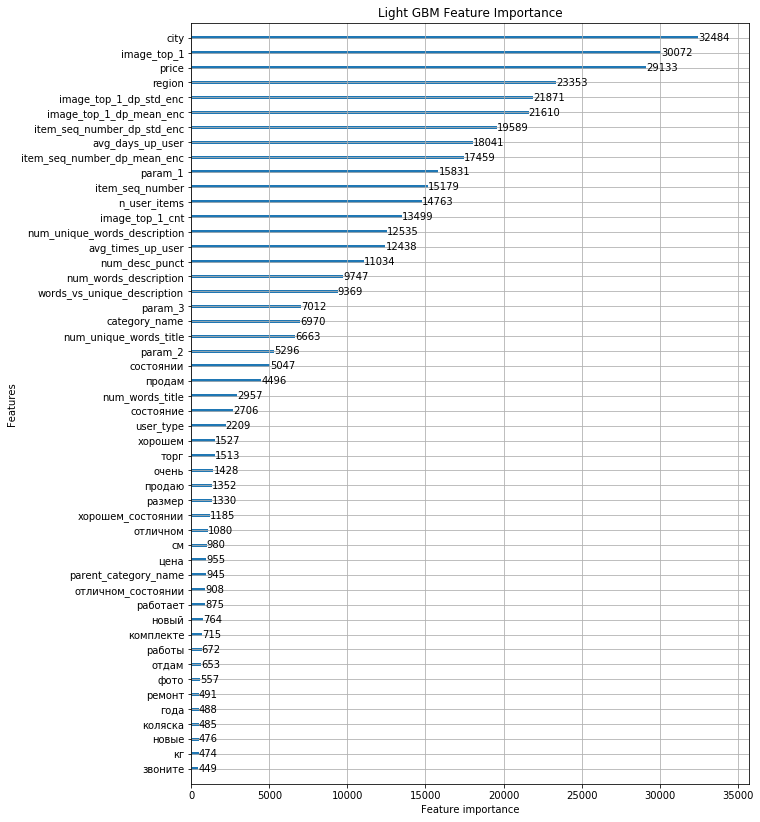

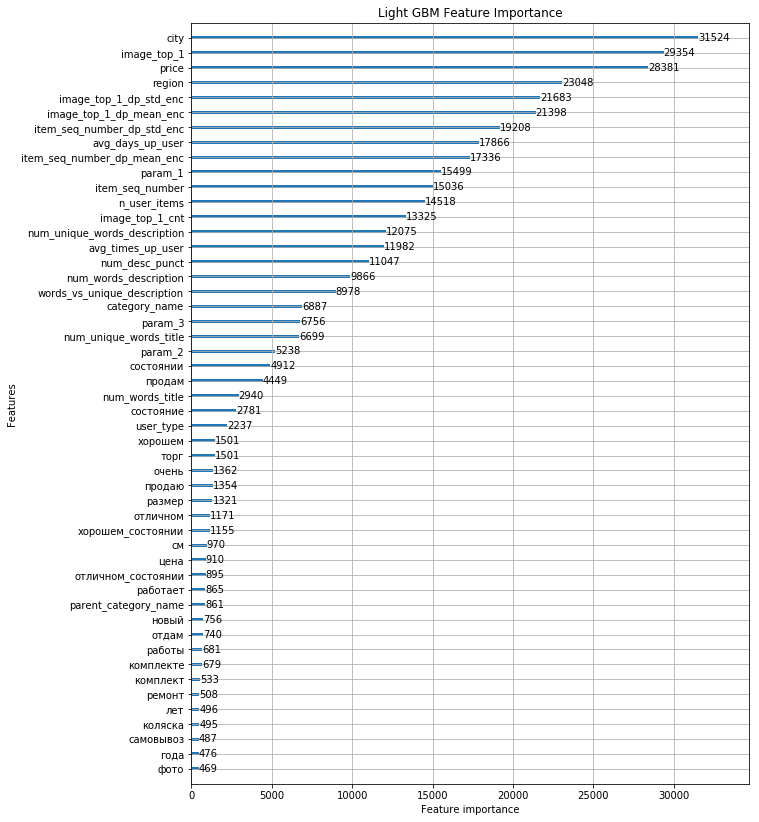

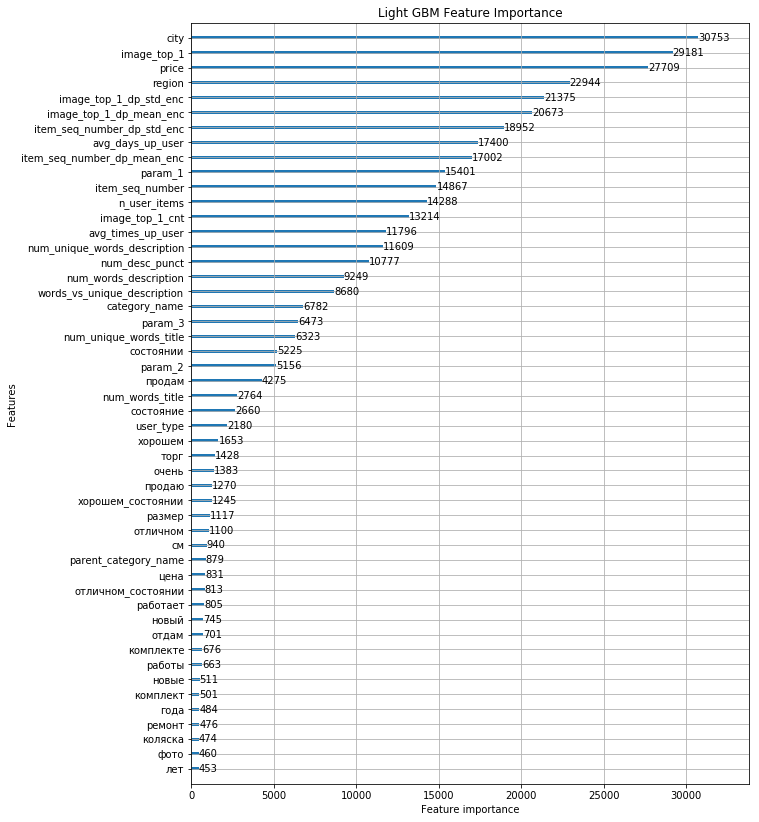

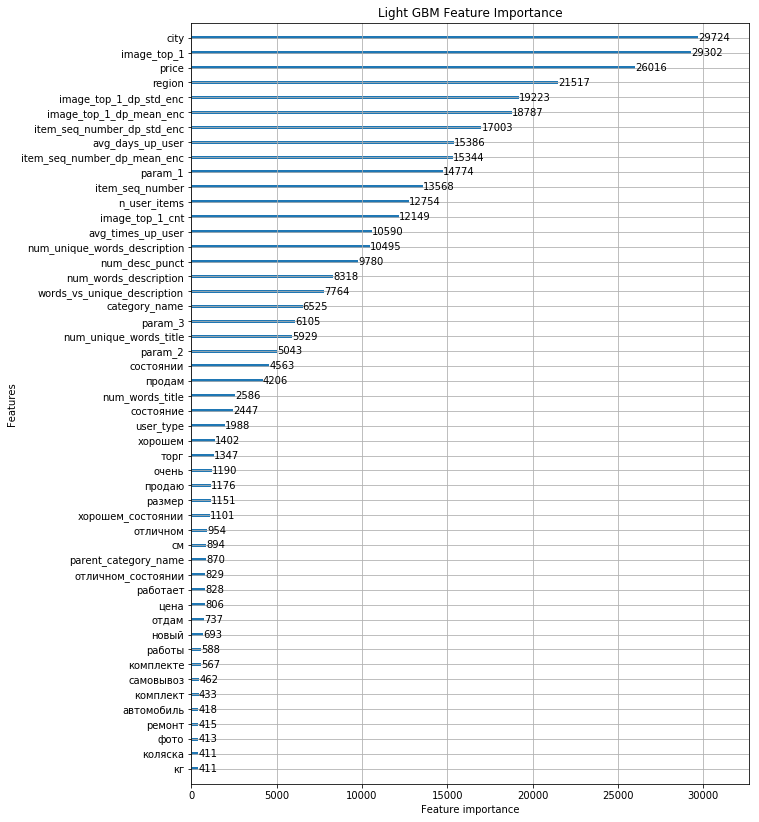

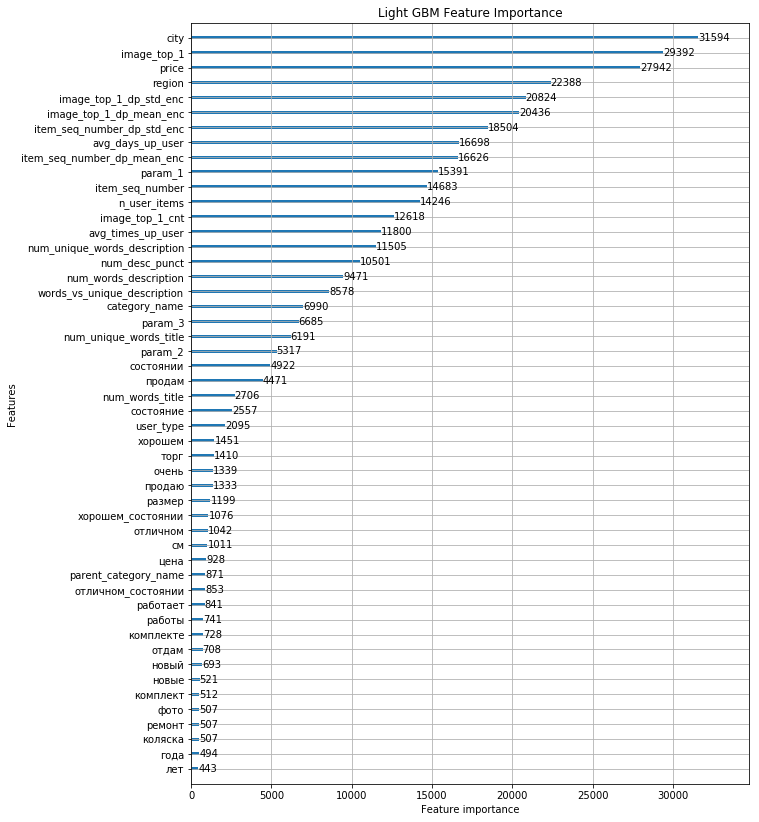

In [32]:
for model in ret_models:
    fig, ax = plt.subplots(figsize=(10, 14))
    lgb.plot_importance(model, max_num_features=50, ax=ax)
    plt.title("Light GBM Feature Importance")
    plt.show()

That looks good. But the model is kind of a black box. It is a good idea to plot the feature importances for our model now.

`avg_days_up`, `avg_times_up_user` and `n_user_items` are our most important engineered features! Looks like we were successful. Now we just have to predict the test matrix and submit!

In [33]:
pd.DataFrame(data=ret, columns=['mean_enc_lgb_pred']).to_csv('mean_enc_lgb_oof_val_pred.csv', index=False)
pd.DataFrame(data=ret_test, columns=['mean_enc_lgb_pred']).to_csv('mean_enc_lgb_oof_test_pred.csv', index=False)

In [35]:
subm = pd.read_csv('sample_submission.csv')
subm['deal_probability'] = np.clip(ret_test, 0, 1)
subm.to_csv('mean_enc_submission.csv', index=False)

In [37]:
import pickle
for md in ret_models:
    with open('models/mean_enc_lgb.model', 'wb') as handle:
        pickle.dump(md, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
ret_test

array([ 0.32159231,  0.17967728,  0.19312391, ...,  0.05805554,
        0.33115088,  0.07384746])

I'll end this kernel with some ideas to improve it:
- Use K-Fold cross validation.
- Try other methods than mean for reducing the aggregated features to one per user (e. g. modus or median).
- Try other gradient boosting libraries like CatBoost or XGBoost.
- Add a temporal dimension to engineered features (e. g. # of items a user put up for sale *per day*).
- Add more advanced text features like pretrained word embeddings.
- Add image features. At the moment we completely ignore images! (as discussed [here](https://www.kaggle.com/c/avito-demand-prediction/discussion/56678), two promising approaches could be [NIMA: Neural Image Assessment](https://arxiv.org/abs/1709.05424) and [Multimedia Features for Click Prediction](https://storage.googleapis.com/kaggle-forum-message-attachments/328059/9411/dimitri-clickadvert.pdf)).
- Normalize text before creating the Tf-Idf matrix (e. g. using [stemming](http://www.nltk.org/howto/stem.html)).
- ~~Learn russian and do in-depth text analysis.~~

Thanks for reading and have fun in this competition!